# Installing and Importing Relevant Packages

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import torch_geometric as torch_geometric
import math

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, DataLoader

import torch_geometric.transforms as T

#from tensorboardX import SummaryWrite
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,GINConv
from torch.distributions import Bernoulli,Categorical

# Generating the dataset

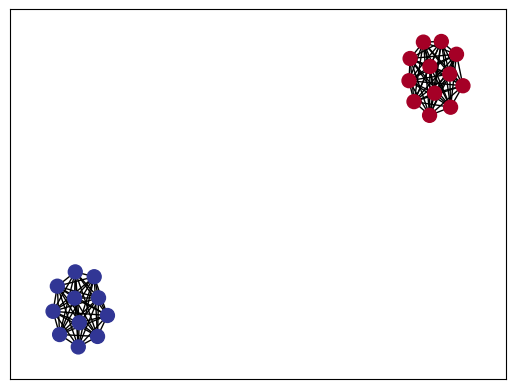

In [ ]:
def generate_multivariate_normal_distribution_graph(
    mean_class1, cov_class1, num_nodes_class1,
    mean_class2, cov_class2, num_nodes_class2
):
    # Generate node features from multivariate normal distributions
    node_features_class1 = np.random.multivariate_normal(mean_class1, cov_class1, num_nodes_class1)
    node_features_class2 = np.random.multivariate_normal(mean_class2, cov_class2, num_nodes_class2)

    # Create a graph
    G = nx.Graph()

    # Add nodes from the first class and connect them among themselves
    for i in range(num_nodes_class1):
        G.add_node(i, feature=node_features_class1[i], class_label=1)

        # Connect nodes within the same class
        for j in range(i + 1, num_nodes_class1):
            G.add_edge(i, j)

    # Add nodes from the second class and connect them among themselves
    for i in range(num_nodes_class2):
        G.add_node(i + num_nodes_class1, feature=node_features_class2[i], class_label=2)

        # Connect nodes within the same class
        for j in range(i + 1, num_nodes_class2):
            G.add_edge(i + num_nodes_class1, j + num_nodes_class1)

    return G

# Example usage:
mean_class1 = [0, 0]
cov_class1 = [[1, 0.5], [0.5, 1]]
num_nodes_class1 = 12

mean_class2 = [2, 2]
cov_class2 = [[1, -0.5], [-0.5, 1]]
num_nodes_class2 = 11

generated_graph = generate_multivariate_normal_distribution_graph(
    mean_class1, cov_class1, num_nodes_class1,
    mean_class2, cov_class2, num_nodes_class2
)

# Visualization
pos = nx.spring_layout(generated_graph)  # Position nodes using a spring layout
node_colors = [generated_graph.nodes[node]['class_label'] for node in generated_graph.nodes]

nx.draw_networkx(generated_graph, pos, node_size=100, node_color=node_colors, cmap=plt.cm.RdYlBu, with_labels=False)
plt.show()


In [ ]:

def convert_to_pyg_data(networkx_graph,y):
    # Extract node features and labels from the NetworkX graph
    node_features = [networkx_graph.nodes[node]['feature'] for node in networkx_graph.nodes]
    #jfstworkx_graph.nodes[node]['class_label'] for node in networkx_graph.nodes]

    # Convert lists to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float32)


    # Extract edges from the NetworkX graph
    edge_index = torch.tensor(list(networkx_graph.edges), dtype=torch.long).t().contiguous()

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index,y=y)

    return data

# Example usage:dssd

#pyg_data = convert_to_pyg_data(generated_graph,0)

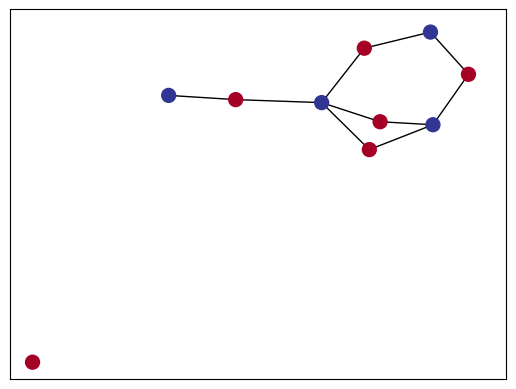

In [ ]:


def generate_disconnected_multivariate_normal_distribution_graph(
    mean_class1, cov_class1, num_nodes_class1,
    mean_class2, cov_class2, num_nodes_class2
):
    # Generate node features from multivariate normal distributions
    node_features_class1 = np.random.multivariate_normal(mean_class1, cov_class1, num_nodes_class1)
    node_features_class2 = np.random.multivariate_normal(mean_class2, cov_class2, num_nodes_class2)

    # Create a graph
    G = nx.Graph()

    # Add nodes from the first class
    for i in range(num_nodes_class1):
        G.add_node(i, feature=node_features_class1[i], class_label=1)

    # Add nodes from the second class
    for i in range(num_nodes_class2):
        G.add_node(i + num_nodes_class1, feature=node_features_class2[i], class_label=2)

    return G

def add_edges_between_classes(graph, num_edges_between_classes):
    class1_nodes = [node for node in graph.nodes if graph.nodes[node]['class_label'] == 1]
    class2_nodes = [node for node in graph.nodes if graph.nodes[node]['class_label'] == 2]

    # Connect nodes between the two classes
    edges_added = 0
    while edges_added < num_edges_between_classes:
        node1 = np.random.choice(class1_nodes)
        node2 = np.random.choice(class2_nodes)

        if not graph.has_edge(node1, node2):
            graph.add_edge(node1, node2)
            edges_added += 1

    return graph
def class1edges(graph, num_edges_between_classes):
    class1_nodes = [node for node in graph.nodes if graph.nodes[node]['class_label'] == 1]
    class2_nodes = [node for node in graph.nodes if graph.nodes[node]['class_label'] == 1]

    # Connect nodes between the two classes
    edges_added = 0
    while edges_added < num_edges_between_classes:
        node1 = np.random.choice(class1_nodes)
        node2 = np.random.choice(class2_nodes)

        if not graph.has_edge(node1, node2):
            graph.add_edge(node1, node2)
            edges_added += 1

    return graph
def class2edges(graph, num_edges_between_classes):
    class1_nodes = [node for node in graph.nodes if graph.nodes[node]['class_label'] == 2]
    class2_nodes = [node for node in graph.nodes if graph.nodes[node]['class_label'] == 2]

    # Connect nodes between the two classes
    edges_added = 0
    while edges_added < num_edges_between_classes:
        node1 = np.random.choice(class1_nodes)
        node2 = np.random.choice(class2_nodes)

        if not graph.has_edge(node1, node2):
            graph.add_edge(node1, node2)
            edges_added += 1

    return graph


# Example usage:
mean_class1 = [0, 0]
cov_class1 = [[1, 0.5], [0.5, 1]]
num_nodes_class1 = 6

mean_class2 = [2, 2]
cov_class2 = [[1, -0.5], [-0.5, 1]]
num_nodes_class2 = 4

num_edges_between_classes = 10  # Adjust as needed

generated_graph = generate_disconnected_multivariate_normal_distribution_graph(
    mean_class1, cov_class1, num_nodes_class1,
    mean_class2, cov_class2, num_nodes_class2
)

# Add edges between classes
generated_graph = add_edges_between_classes(generated_graph, num_edges_between_classes)

# Visualization
pos = nx.spring_layout(generated_graph)  # Position nodes using a spring layout
node_colors = [generated_graph.nodes[node]['class_label'] for node in generated_graph.nodes]

nx.draw_networkx(generated_graph, pos, node_size=100, node_color=node_colors, cmap=plt.cm.RdYlBu, with_labels=False)
plt.show()



In [ ]:
def plot_graph_with_color(graph, point1, point2):
    # Convert PyTorch Geometric graph to NetworkX graph
    nx_graph = to_networkx(graph,to_undirected=True)
    point1=torch.tensor(point1)
    point2=torch.tensor(point2)

    # Calculate distances from each node to the two points
    distances_to_point1 = torch.norm(graph.pos - point1, dim=1)
    distances_to_point2 = torch.norm(graph.pos - point2, dim=1)

    # Color nodes based on proximity to points
    node_colors = ['blue' if dist_to_point1 < dist_to_point2 else 'red'
                   for dist_to_point1, dist_to_point2 in zip(distances_to_point1, distances_to_point2)]

    # Plot the graph
    pos = {i: pos.numpy() for i, pos in enumerate(graph.pos)}
    #plt.figure(figsize=(8, 6))
    nx.draw_networkx(nx_graph, pos, node_color=node_colors, with_labels=False, node_size=50, cmap=plt.cm.coolwarm)
    # plt.title('Graph with Node Color Based on Proximity to Points')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    plt.show()

In [ ]:
dataset=[]

In [ ]:
num_graphs = 1000


for _ in range(num_graphs):
    num_nodes_class1 = np.random.randint(5, 10)
    num_nodes_class2 = np.random.randint(5, 10)
    num_edges_between_classes = np.random.randint(5, 15)


    generated_graph = generate_disconnected_multivariate_normal_distribution_graph(
        mean_class1, cov_class1, num_nodes_class1,
        mean_class2, cov_class2, num_nodes_class2
    )
    generated_graph = add_edges_between_classes(generated_graph, num_edges_between_classes)

    pyg_data = convert_to_pyg_data(generated_graph,1)
    dataset.append(pyg_data)

<ipython-input-4-f5ea4315a584>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(node_features, dtype=torch.float32)


In [ ]:
num_graphs = 1000


for _ in range(num_graphs):
    num_nodes_class1 = np.random.randint(5, 10)
    num_nodes_class2 = np.random.randint(5, 10)
    num_edges_between_classes = np.random.randint(6, 15)


    generated_graph = generate_disconnected_multivariate_normal_distribution_graph(
        mean_class1, cov_class1, num_nodes_class1,
        mean_class2, cov_class2, num_nodes_class2
    )
    generated_graph = class1edges(generated_graph, num_edges_between_classes)
    generated_graph=  class2edges(generated_graph, num_edges_between_classes)

    pyg_data = convert_to_pyg_data(generated_graph,0)
    dataset.append(pyg_data)

In [ ]:
import torch

# Example list of tensors (replace this with your actual dataset)
#my_dataset = [torch.randn((3, 64, 64)) for _ in range(100)]

# Define the path to the local folder on Colab where you want to save the dataset
save_path_dataset = '/content/intrainter.pt'

# Save the dataset (list of tensors)
torch.save(graphs, save_path_dataset)



In [ ]:
#Code for loading saved dataset


# Define the path to the saved dataset on your local machine


# Define the path to the saved dataset on your local machine
load_path_dataset = '/content/intrainter.pt'

# Load the saved dataset (list of tensors)
loaded_dataset = torch.load(load_path_dataset)


# Load the saved dataset (list of tensors)
loaded_dataset = torch.load(load_path_dataset)
graphs=loaded_dataset

# Defining and Training the Classifier

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNEncoder(torch.nn.Module):
    def __init__(self, inputdim,hidden_channels):
        super(GCNEncoder, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(inputdim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.bn(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return x

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)
class CombinedModel(torch.nn.Module):
    def __init__(self,inputdim, hidden_channels, num_classes):
        super(CombinedModel, self).__init__()
        self.encoder = GCNEncoder(inputdim,hidden_channels)
        self.classifier = LinearClassifier(input_dim=hidden_channels, num_classes=num_classes)

    def forward(self, x, edge_index, batch):
        # Get the embeddings from the encoder
        embeddings = self.encoder(x, edge_index, batch)

        # Get the logits from the classifier
        logits = self.classifier(embeddings)

        return embeddings, logits
num_features=2
inputdim=num_features
model=CombinedModel(inputdim, hidden_channels=64,num_classes=2)


In [ ]:
## Shuffle the data & create train-test split
import random
random.shuffle(dataset)

# Split the data into training and testing sets
split_idx = int(0.8 * len(dataset))
train_data = dataset[split_idx:]
test_data = dataset[:split_idx]
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Add a learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
# def train():
#     model.train()

#     for epoch in range(num_epochs):
#         for data in train_loader:  # Iterate in batches over the training dataset.
#             embedding,  out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#             #print(out)
#             loss = criterion(out, data.y)  # Compute the loss.
#             loss.backward()  # Derive gradients.
#             optimizer.step()  # Update parameters based on gradients.
#             optimizer.zero_grad()  # Clear gradients.

#         # Update the learning rate scheduler
#         scheduler.step()

#         # Print the current learning rate every epoch (optional)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}",loss)
#         # train_acc = test(train_loader)
#         # test_acc = test(test_loader)
#         # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
def train():
    model.train()

    for epoch in range(num_epochs):
        for data in train_loader:  # Iterate in batches over the training dataset.
            # Forward pass
            x, edge_index, batch = data.x, data.edge_index, data.batch
            embedding, out = model(x, edge_index, batch)

            # Compute the loss
            loss = criterion(out, data.y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()

        # Print the current learning rate and loss every epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}, Loss: {loss.item()}")

# Set the number of epochs
num_epochs = 500

# Call the training loop
train()

Epoch 1/500, Learning Rate: 0.0099, Loss: 0.085325688123703
Epoch 2/500, Learning Rate: 0.009801, Loss: 0.31208857893943787
Epoch 3/500, Learning Rate: 0.00970299, Loss: 0.22458410263061523
Epoch 4/500, Learning Rate: 0.0096059601, Loss: 0.012173792347311974
Epoch 5/500, Learning Rate: 0.009509900499, Loss: 0.02128368243575096
Epoch 6/500, Learning Rate: 0.00941480149401, Loss: 0.0906449630856514
Epoch 7/500, Learning Rate: 0.0093206534790699, Loss: 0.06241701543331146
Epoch 8/500, Learning Rate: 0.0092274469442792, Loss: 0.09058666229248047
Epoch 9/500, Learning Rate: 0.009135172474836408, Loss: 0.07538404315710068
Epoch 10/500, Learning Rate: 0.009043820750088045, Loss: 0.23289133608341217
Epoch 11/500, Learning Rate: 0.008953382542587164, Loss: 0.04711398109793663
Epoch 12/500, Learning Rate: 0.008863848717161293, Loss: 0.040688034147024155
Epoch 13/500, Learning Rate: 0.00877521022998968, Loss: 0.2984064519405365
Epoch 14/500, Learning Rate: 0.008687458127689783, Loss: 0.1065125092

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataset, class_dict):
    """
    Evaluate the model on the provided dataset, compute the confusion matrix,
    and plot it with class names.

    Parameters:
    - model: Trained GNN model
    - dataset: List of data objects
    - class_dict: Dictionary mapping class labels to class names, e.g., {0: 'Class A', 1: 'Class B'}
    """

    # Step 1: Evaluate the model and get predictions and true labels
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataset:
            _, out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            data.y=torch.tensor(data.y)
            all_preds.append(pred.numpy().flatten())
            all_labels.append(data.y.numpy().flatten())

    print(all_labels)
    print(all_preds)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Step 2: Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Step 3: Plot the confusion matrix
    class_names = [class_dict[i] for i in range(len(class_dict))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# Assuming the class labels are {0: 'Mutagenic', 1: 'Non-Mutagenic'}
#class_dict = {0: 'Mutagenic', 1: 'Non-Mutagenic'}

# Example dataset (assuming it's a list of data objects)
# dataset = [...]

# Call the function with the model, dataset (as a list), and class dictionary
#plot_confusion_matrix(model, dataset, class_dict)


[array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([0]), arr

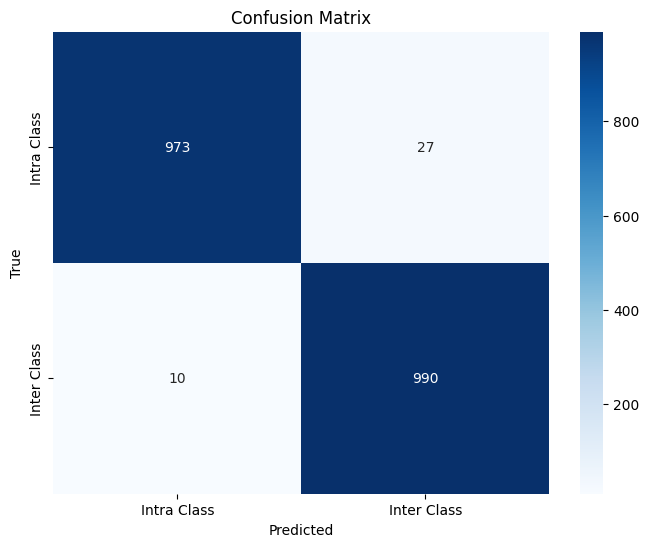

In [ ]:
class_dict={0:'Intra Class',1:'Inter Class'}
plot_confusion_matrix(model,dataset,class_dict)

In [ ]:
#Loading Saved Model



load_path = '/content/intra-inter.pth'



# Initialize the model architecture

# Load the saved model weights
model.load_state_dict(torch.load(load_path))

# Set the model to evaluation mode
model.eval()

In [ ]:
# Define the path to the local folder on Colab where you want to save the model
save_path = '/content/intra-inter.pth'

# Save the model
torch.save(model.state_dict(), save_path)

In [ ]:
import torch
from sklearn.metrics import f1_score
from torch_geometric.data import DataLoader

def calculate_f1_score(model, dataset):
    model.eval()  # Set model to evaluation mode
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #model.to(device)  # Move model to the appropriate device (GPU if available)

    y_true = []
    y_pred = []

    #loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for data in dataset:
        #data = data.to(device)
        with torch.no_grad():
            _,output = model(data.x, data.edge_index, data.batch)
        predicted_labels = output.argmax(dim=1)
        y_true.append(data.y)
        y_pred.extend(predicted_labels)

    f1 = f1_score(y_true, y_pred, average=None)  # Calculate F1 score
    return f1
f1=calculate_f1_score(model,dataset)
print(f1)


[0.9813414  0.98165592]


In [ ]:
def degree_distribution(data, N):
    # Find all unique nodes present in the edge index tensor
    all_nodes = torch.unique(torch.cat((data.edge_index[0], data.edge_index[1])))

    # Calculate the number of nodes
    num_nodes = int(all_nodes.max()) + 1 if all_nodes.numel() > 0 else 0  # If there are no nodes, set num_nodes to 0

    # Calculate the degree of each node
    degrees = torch.bincount(data.edge_index[0], minlength=num_nodes)

    # Convert degrees to degree distribution
    degree_values = torch.bincount(degrees)

    # Make sure the tensor is of length N
    degree_distribution = torch.cat((degree_values, torch.zeros(max(N - len(degree_values), 0)).to(degree_values.device)))

    return degree_distribution


def clustering_coefficient(data):
    # Ensure the graph is undirected
    #data = to_undirected(data)

    # Calculate the number of nodes
    num_nodes = data.x.shape[0]

    # Calculate the number of triangles each node is involved in
    num_triangles = torch.zeros(num_nodes, dtype=torch.float)

    # Calculate the number of connected triples each node is involved in
    num_connected_triples = torch.zeros(num_nodes, dtype=torch.float)

    # Iterate over each edge in the graph
    for i, j in data.edge_index.t().tolist():
        # Get the neighbors of node i and node j
        neighbors_i = set(data.edge_index[1][data.edge_index[0] == i].tolist())
        neighbors_j = set(data.edge_index[1][data.edge_index[0] == j].tolist())

        # Calculate the number of common neighbors between i and j
        common_neighbors = neighbors_i.intersection(neighbors_j)

        # Update the number of triangles and connected triples for nodes i and j
        num_triangles[i] += len(common_neighbors)
        num_triangles[j] += len(common_neighbors)
        num_connected_triples[i] += len(neighbors_i) - 1
        num_connected_triples[j] += len(neighbors_j) - 1

    # Print intermediate results for debugging
    #print("Number of triangles per node:", num_triangles)
    #print("Number of connected triples per node:", num_connected_triples)

    # Calculate the local clustering coefficient for each node
    local_clustering_coefficient = (num_triangles / 2) / num_connected_triples
    local_clustering_coefficient[torch.isnan(local_clustering_coefficient)] = 0  # Set NaN values to 0

    # Print intermediate results for debugging
    #print("Local clustering coefficient per node:", local_clustering_coefficient)

    # Calculate the average clustering coefficient
    avg_clustering_coefficient = local_clustering_coefficient.mean()

    return avg_clustering_coefficient

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues.astype(np.complex128)




# Function to Calculate MMD using Gaussian Kernel

In [ ]:
def mmd_kernel(X, Y, kernel_func):
    """
    Compute Maximum Mean Discrepancy (MMD) between two samples using a given kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - kernel_func: function, kernel function to compute pairwise kernel values

    Returns:
    - mmd: float, Maximum Mean Discrepancy
    """
    m, n = len(X), len(Y)

    # Compute kernel matrices
    K_xx = kernel_func(X, X)
    K_yy = kernel_func(Y, Y)
    K_xy = kernel_func(X, Y)

    # Compute MMD statistic
    mmd = 1.0 / (m * (m - 1)) * torch.sum(K_xx - torch.diag(torch.diagonal(K_xx))) + \
          1.0 / (n * (n - 1)) * torch.sum(K_yy - torch.diag(torch.diagonal(K_yy))) - \
          2.0 / (m * n) * torch.sum(K_xy)

    return mmd.item()  # Convert the result to a Python float

# Example of using a Gaussian (RBF) kernel function for PyTorch
def gaussian_kernel(X, Y, sigma=1.0):
    """
    Gaussian (RBF) kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - sigma: float, bandwidth parameter of the kernel

    Returns:
    - K: torch.Tensor, shape (n_samples, m_samples), kernel matrix
    """
    pairwise_sq_dists = torch.sum(X**2, dim=1, keepdim=True) + torch.sum(Y**2, dim=1, keepdim=True).t() - 2 * torch.mm(X, Y.t())
    K = torch.exp(-pairwise_sq_dists / (2.0 * sigma**2))
    return K




In [ ]:
def separate_graphs_by_class(model, dataset, N):
    """
    Separates graphs in the dataset into two classes based on the model's predictions.
    Also computes latent embeddings, degree distribution, clustering coefficients,
    and spectrum distributions for each class.

    Args:
        model (torch.nn.Module): The trained GNN model for predictions.
        dataset (list): A list of graph data objects to classify.
        N (int): Number of nodes (used for computing degree distribution and spectrum).

    Returns:
        dict: A dictionary containing data, embeddings, and metrics for each class.
    """
    # Initialize containers for class-separated data
    results = {
        0: {
            "data": [],
            "latent_data": [],
            "degreedist": [],
            "cluscoeff": [],
            "spec": [],
        },
        1: {
            "data": [],
            "latent_data": [],
            "degreedist": [],
            "cluscoeff": [],
            "spec": [],
        },
    }

    for data in dataset:
        model.eval()  # Set model to evaluation mode
        embedding, out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1).item()  # Classify the graph

        # Append data and metrics to the appropriate class
        results[pred]["data"].append(data)
        results[pred]["latent_data"].append(embedding)
        results[pred]["degreedist"].append(degree_distribution(data, N))
        results[pred]["cluscoeff"].append(clustering_coefficient(data))
        results[pred]["spec"].append(spectrum_distribution(data, N))

    print(f"Class 0: {len(results[0]['data'])} graphs")
    print(f"Class 1: {len(results[1]['data'])} graphs")

    return results


In [ ]:
# Assuming model, dataset, and N are already defined
N=25

results = separate_graphs_by_class(model, dataset, N)

# Access class-specific data
data1 = results[0]["data"]
latent_data1 = results[0]["latent_data"]
degreedist1 = results[0]["degreedist"]
cluscoeff1 = results[0]["cluscoeff"]
spec1 = results[0]["spec"]

data2 = results[1]["data"]
latent_data2 = results[1]["latent_data"]
degreedist2 = results[1]["degreedist"]
cluscoeff2 = results[1]["cluscoeff"]
spec2 = results[1]["spec"]


Class 0: 983 graphs
Class 1: 1017 graphs


In [ ]:
def Dpc(dataset,threshold):
  boundary1=[]
  boundary2=[]
  m=torch.nn.Softmax(dim=1)
  for i in range(len(dataset)):
      model.eval()
      data=dataset[i]
      embedding , out = model(data.x, data.edge_index, data.batch)
      probs=m(out)
      #out=torch.nn.Softmax(out,dim=0)
      #pred = out.argmax(dim=1)
      if(threshold<probs[0][0]):
          boundary1.append(data)
          #latent_data1.append(embedding)
      if(threshold <probs[0][1]):
          boundary2.append(data)
  return boundary1 , boundary2


In [ ]:
def GraphRepModel(N,classdata):
    B=np.zeros(N)# Node Type Matrix for nodes of 10 types
    X=np.zeros((N,2))
    numgraphs=len(classdata)
    workingdata=classdata

    #Learning the on/off bit and node representations
    for i in range(numgraphs):#len(data1))
        data=workingdata[i]
        x=data.x
        k=len(data.x) # keeping tab of the number of nodes in the ith graph
        #print(k)
        x=x.numpy()

        B[0:k]+=1
        #print(B)
        X[:x.shape[0], :] += x
    B1=B
    B=np.reshape(B,(20,-1))
    mean_estimate=X/B

    #print(mean_estimate)
    covarr=np.zeros((2,2,N))

    for i in range(numgraphs):
        data=workingdata[i]
        x=data.x
        #print(len(x))
        x=x.numpy()
        subtracted_array = x-mean_estimate[:x.shape[0], :]
        result_matrices=[]
        for row in subtracted_array:
          element = row.reshape(2, 1)  # Reshape to a 2x1 element
          result_matrix = np.dot(element, element.T)  # Multiply by its transpose
          result_matrices.append(result_matrix)

    # Concatenate the resulting 2x2 matrices along the third dimension to create a 3D array
        result_array = np.stack(result_matrices, axis=2)
        #print(result_array.shape)
        covarr[:, :, :result_array.shape[2]] += result_array
    print(covarr.shape)
    covariance_estimate=covarr/B[:,None,None]
    #print(covariance_estimate.shape)
    print(covariance_estimate.shape)
    result_list=[]
    for i in range(20):
        result_list.append(covarr[:, :, i] / B[i])

    # Convert the list of results back to a NumPy array
    result = np.stack(result_list, axis=2)
    print(result.shape)
    Bdist=B/numgraphs
    Adj=np.zeros((N,N))# Edge type count for only two types edge present/edge absent
    for i in range(len(workingdata)):
        data=workingdata[i]
        adj=data.edge_index
        rowlen=len(adj[0][:])
        #print(rowlen)
        #print(adj[:][0])
        #print(adj[:][1])
        for j in range(rowlen):
            k1=adj[0][j]
            k2=adj[1][j]
            Adj[k1][k2]+=1

    #Learning the parameters for the distribution of nodes
    #numgraphs=len(data1)
    #X=X/numgraphs #converting X to the node distribution matrix
    Adj=Adj/numgraphs
    return Bdist, mean_estimate, result, Adj


In [ ]:
from torch_geometric.utils import to_networkx
def graphsampler(N,Bdist,mean_estimate, result, Adj,show=False):
  Bdist=np.concatenate(Bdist)
  #print(Bdist)prateek shrivastava
  samples = [np.random.choice([0, 1], p=[1 - p, p]) for p in Bdist]
  #print(samples[1])
  nodefeat=[]
  for i in range(N):
    if(samples[i]!=0):
      meanvec=mean_estimate[i,:]
      covarvec=result[:,:,i]
      normalsamples = np.random.multivariate_normal(meanvec, covarvec, 1)
      nodefeat.append(normalsamples)
  Adjacencymat=np.random.binomial(1,Adj)
  #print(Adjacencymat.shape)
  #print(Adjacencymat[3][5])
  nodefeat=np.vstack(nodefeat)

  nodefeat=torch.tensor(nodefeat)
  #nodefeat=nodefeat.double()
  #print(nodefeat)
  merged_array = np.vstack(nodefeat)
  #print(nodefeat.shape)
  k=nodefeat.shape[0]
  for i in range(N):
    for j in range(N):
      if (i>k-1 or j> k-1):
        Adjacencymat[i][j]=0
    # Convert the NumPy array to a PyTorch tensor
  adjacency_matrix = torch.tensor(Adjacencymat)

  # Find the non-zero indices in the adjacency matrix
  edge_indices = torch.nonzero(adjacency_matrix, as_tuple=False).t()
  edge_indices=edge_indices.long()
  newdata=Data(x=nodefeat,edge_index=edge_indices)
  newdata.x=newdata.x.float()
  newdata.pos=newdata.x
  #print(newdata.x.dtype)
  #print(newdata.x)
  #print(newdata.edge_index)
  embedding, out=model(newdata.x,newdata.edge_index,newdata.batch)
  soft=torch.nn.Softmax(dim=1)
  explainergraph=to_networkx(newdata,to_undirected=True)
  degreedist=degree_distribution(newdata,N)
  cluscoeffexp=clustering_coefficient(newdata)
  specdist=spectrum_distribution(newdata,N)
  if show:
    plot_graph_with_color(newdata,mean_class1,mean_class2)

  problities=soft(out)
  explainernodes=nx.number_of_nodes(explainergraph)
  explaineredges=nx.number_of_edges(explainergraph)
  explainerdensity=(explaineredges)/(explainernodes*explainernodes)
  return problities, explainerdensity, embedding, degreedist, cluscoeffexp, specdist,explainergraph






In [ ]:
import statistics
import torch

def target_class_analysis( N,Bdist,mean_estimate,result,Adj,latent,numexplanations=50, numsample=10, label=0,show=False):
    """
    Analyzes the robustness of a target class in graph data by sampling graphs
    and evaluating accuracy, density, and other metrics.

    Args:
        X: Node feature matrix.
        Adj: Adjacency matrix.
        N: Number of nodes in the graph.
        latent: Latent space embeddings of the original data.
        numexplanations: Number of explanations to generate.
        numsample: Number of samples to generate.
        label: Target class label to analyze (default: 0).

    Returns:
        meanaccuracy: Mean accuracy.
        stdaccuracy: Standard deviation of accuracies.
        meandensity: Mean density.
        stddensity: Standard deviation of densities.
        MMD: Maximum Mean Discrepancy (MMD) distance.
        degreedistlist: Degree distributions across samples.
        cluslist: Clustering coefficients across samples.
        speclist: Spectral metrics across samples.
    """
    accuracy = []
    density = []
    embeddings = []
    degreedistlist = []
    cluslist = []
    speclist = []


    for _ in range(numexplanations):

        max_prob = 0

        for _ in range(numsample):
            probabilities, explainerdensity, embedding, degreedistb, clus, spec,explainergraph =graphsampler(N, Bdist, mean_estimate, result, Adj)

            if probabilities[0][label] > max_prob:
                sampleaccuracy = probabilities[0][label]
                sampledensity = explainerdensity
                sampleembedding = embedding
                sampledeg = degreedistb
                sampleclus = clus
                samplespec = spec
                bestgraph=explainergraph
                max_prob = probabilities[0][label]
        if show:
          plot_graph_with_color(bestgraph,mean_class1,mean_class2)

        accuracy.append(sampleaccuracy)
        density.append(sampledensity)
        embeddings.append(sampleembedding)
        degreedistlist.append(sampledeg)
        cluslist.append(sampleclus)
        speclist.append(samplespec)

    meanaccuracy = torch.mean(torch.tensor(accuracy))
    stdaccuracy = torch.std(torch.tensor(accuracy))
    meandensity = statistics.mean(density)
    stddensity = statistics.stdev(density)

    MMDemb = mmd_kernel(torch.cat(latent, dim=0), torch.cat(embeddings, dim=0), gaussian_kernel)

    return meanaccuracy, stdaccuracy, meandensity, stddensity, MMDemb, degreedistlist, cluslist, speclist


In [ ]:
#newdata2=align_data_degreewise(data2)

N=20
Bdist, mean_estimate, result, Adj =GraphRepModel(N,data1)
latent_data=latent_data1
classlabel=0
meanaccuracy, stdaccuracy, meandensity, stddensity, MMDemb, degreedistlist, cluslist, speclist=target_class_analysis(N, Bdist, mean_estimate, result, Adj,latent_data,numexplanations=2, numsample=10, label=classlabel)


<ipython-input-21-2b160a82dbcc>:20: RuntimeWarning: invalid value encountered in divide
  mean_estimate=X/B
<ipython-input-21-2b160a82dbcc>:42: RuntimeWarning: divide by zero encountered in divide
  covariance_estimate=covarr/B[:,None,None]
<ipython-input-21-2b160a82dbcc>:42: RuntimeWarning: invalid value encountered in divide
  covariance_estimate=covarr/B[:,None,None]
<ipython-input-21-2b160a82dbcc>:47: RuntimeWarning: invalid value encountered in divide
  result_list.append(covarr[:, :, i] / B[i])


(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)


In [ ]:
print("Accuracy is",meanaccuracy,"std is",stdaccuracy)
print("Density is", meandensity,"std is",stddensity)


Accuracy is tensor(0.9999) std is tensor(8.7918e-05)
Density is 0.1072334259147446 std is 0.00734345890376079


# Generate Sensitivity Analysis Plots

In [ ]:
def Dpc(dataset,threshold):
  boundary1=[]
  boundary2=[]
  m=torch.nn.Softmax(dim=1)
  for i in range(len(dataset)):
      model.eval()
      data=dataset[i]
      embedding , out = model(data.x, data.edge_index, data.batch)
      probs=m(out)
      #out=torch.nn.Softmax(out,dim=0)
      #pred = out.argmax(dim=1)
      if(threshold<probs[0][0]):
          boundary1.append(data)
          #latent_data1.append(embedding)
      if(threshold <probs[0][1]):
          boundary2.append(data)
  return boundary1 , boundary2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_with_error(mean, std, threshold, label, numsample,title=None, ax=None):
    """
    Plot mean with error bars.

    Parameters:
        mean (array_like): Array containing mean values.
        std (array_like): Array containing standard deviation values.
        threshold (array_like): Array containing threshold values.
        label (str): Label for the data.
        color (str): Color of the line.
        numsample (int): Sample number.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If not provided, a new figure will be created.
    """
    # Flatten the arrays
    mean=torch.tensor(mean,dtype=torch.float32)
    std=torch.tensor(std,dtype=torch.float32)
    mean = np.array(mean).flatten()
    std = np.array(std).flatten()
    threshold = np.array(threshold).flatten()
    # Select color automatically
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color = colors[numsample % 10]  # Cycle through colors

    # Plotting
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(threshold, mean, yerr=std, fmt='-', color=color, label=f'NumSample={numsample}')  # '-' for line

    # Adding labels and title
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    ax.legend(loc='lower right',fontsize='small')  # Show legend
    ax.grid(True)  # Add grid
# Create a figure outside the function
# fig, ax = plt.subplots()
# plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=1,ax=ax)
# plot_mean_with_error(Mean2,Std2,Threshold,label='class1',numsample=2,ax=ax)
# plt.show()


983
1017
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)


<ipython-input-21-2b160a82dbcc>:20: RuntimeWarning: invalid value encountered in divide
  mean_estimate=X/B
<ipython-input-21-2b160a82dbcc>:42: RuntimeWarning: divide by zero encountered in divide
  covariance_estimate=covarr/B[:,None,None]
<ipython-input-21-2b160a82dbcc>:42: RuntimeWarning: invalid value encountered in divide
  covariance_estimate=covarr/B[:,None,None]
<ipython-input-21-2b160a82dbcc>:47: RuntimeWarning: invalid value encountered in divide
  result_list.append(covarr[:, :, i] / B[i])


(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
982
1017
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
980
1013
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
980
1010
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
979
1008
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
976
1007
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
971
1005
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
965
999
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
960
995
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
949
988
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
983
1017
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
982
1017
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
980
1013
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 

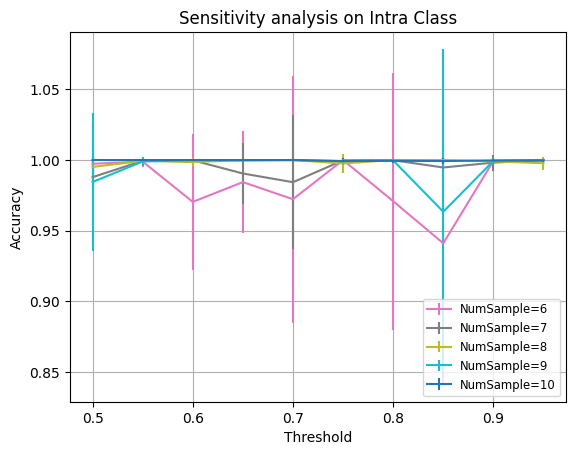

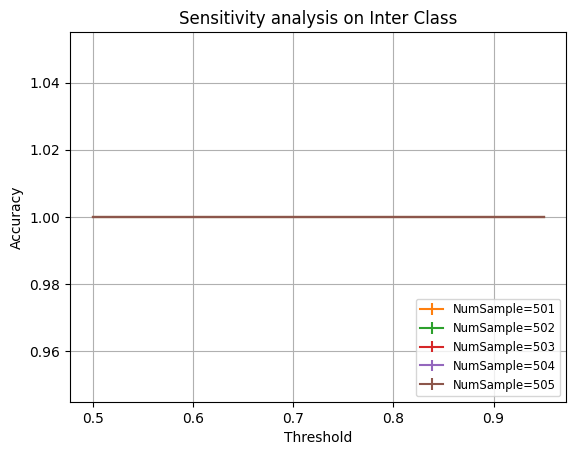

In [ ]:
samplerange=6
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
numsample1=5
numsample2=500
graphs=list(dataset)
for numsample in range(1,samplerange):
  threshold=0.5
  Threshold=[]
  Mean1=[]
  Std1=[]
  Mean2=[]
  Std2=[]

  while(threshold<1):
    Threshold.append(threshold)
    data1 , data2=Dpc(graphs,threshold)
    print(len(data1))
    print(len(data2))

    Bdist1, mean_estimate1, result1, Adj1 =GraphRepModel(N,data1)
    Bdist2, mean_estimate2, result2, Adj2 =GraphRepModel(N,data2)
    mean1,std1,*_=target_class_analysis(N, Bdist1, mean_estimate1, result1, Adj1,latent_data1,numexplanations=10, numsample=numsample1, label=0)
    Mean1.append(mean1)
    Std1.append(std1)
    mean2,std2,*_=target_class_analysis(N, Bdist2, mean_estimate2, result2, Adj2,latent_data2,numexplanations=3  , numsample=numsample2, label=1)
    Mean2.append(mean2)
    Std2.append(std2)
    threshold+=0.05
  numsample1+=1
  numsample2+=1
  plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=numsample1,title='Sensitivity analysis on Intra Class',ax=ax1)
  plot_mean_with_error(Mean2,Std2,Threshold,label='class2',numsample=numsample2,title='Sensitivity analysis on Inter Class',ax=ax2)

plt.show()



Defining the Mixture of Two Distributions

In [ ]:
Bdist1, mean_estimate1, result1, Adj1 =GraphRepModel(N,data1)
Bdist2, mean_estimate2, result2, Adj2 =GraphRepModel(N,data2)
mean_estimates=[mean_estimate1,mean_estimate2]
covar_estimates=[result1,result2]

<ipython-input-21-2b160a82dbcc>:20: RuntimeWarning: invalid value encountered in divide
  mean_estimate=X/B
<ipython-input-21-2b160a82dbcc>:42: RuntimeWarning: divide by zero encountered in divide
  covariance_estimate=covarr/B[:,None,None]
<ipython-input-21-2b160a82dbcc>:42: RuntimeWarning: invalid value encountered in divide
  covariance_estimate=covarr/B[:,None,None]
<ipython-input-21-2b160a82dbcc>:47: RuntimeWarning: invalid value encountered in divide
  result_list.append(covarr[:, :, i] / B[i])


(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)
(2, 2, 20)
(20, 2, 2, 20)
(2, 2, 20)


In [ ]:
mixcoeff=0.5
Bdistmix=mixcoeff*Bdist1+(1-mixcoeff)*Bdist2
Adjmix=mixcoeff*Adj1+(1-mixcoeff)*Adj2


In [ ]:
import torch

def boundary_analysis(N, Bdistmix, mean_estimates,covar_estimates, Adj,numboundary, numsample, label1, label2):
    accuracies = []
    embeddings = []

    for _ in range(numboundary):
        min_difference = float('inf')
        sample_accuracy = None
        sample_embedding = None
        mean_estimate=random.choice(mean_estimates)
        result=random.choice(covar_estimates)

        for _ in range(numsample):
            probabilities, _, embedding,*_ = graphsampler(N, Bdist, mean_estimate, result, Adj)

            # Difference in class scores
            score_diff = abs(probabilities[0][label1] - probabilities[0][label2])

            if score_diff < min_difference:
                min_difference = score_diff
                sample_accuracy = probabilities[0][label1]
                sample_embedding = embedding

        accuracies.append(sample_accuracy)
        embeddings.append(sample_embedding)

    # Calculate mean and standard deviation of accuracies
    mean_accuracy = torch.mean(torch.tensor(accuracies))
    std_accuracy = torch.std(torch.tensor(accuracies))

    return mean_accuracy, std_accuracy, embeddings



In [ ]:
bdmean,bdstd,embeddings=boundary_analysis(N, Bdistmix, mean_estimates,covar_estimates, Adjmix,10, 500, 0, 1)
print(bdmean,bdstd)


tensor(0.4997) tensor(0.0024)


In [ ]:
# Computing boundary metrics
import torch
import torch.nn.functional as F

def boundary_margin(embeddings_c1, embeddings_c2):
    """
    Compute the boundary margin.

    Args:
    - embeddings_c1 (torch.Tensor): Embeddings of class c1 graphs.
    - embeddings_c2 (torch.Tensor): Embeddings of boundary graphs between class c1 and c2.

    Returns:
    - margin (float): The boundary margin.

    """
    embeddings_c1=torch.cat(embeddings_c1,dim=0)
    embeddings_c2=torch.cat(embeddings_c2,dim=0)
    distances = torch.norm(embeddings_c1 - embeddings_c2, dim=1)
    margin = torch.min(distances).item()
    return margin

def boundary_thickness(embeddings_c1, embeddings_c1_c2, model, c1, c2, gamma=0.75, num_points=100):
    thickness_values = []

    for emb_c1, emb_c1_c2 in zip(embeddings_c1, embeddings_c1_c2):
        t_values = torch.linspace(0, 1, num_points)
        h_t = (1 - t_values).unsqueeze(1) * emb_c1 + t_values.unsqueeze(1) * emb_c1_c2
        #print(model(h_t).size())

        # Compute the logits
        logits_h_t = model(h_t)  # Assuming `model` is your classifier
        probs_h_t = F.softmax(logits_h_t, dim=1)

        # Compute the integrand
        integrand = (gamma > (probs_h_t[:, c1] - probs_h_t[:, c2])).float()

        # Approximate the integral using the trapezoidal rule
        integral = torch.trapz(integrand, t_values)

        # Compute the thickness value
        thickness_value = (emb_c1 - emb_c1_c2).norm() * integral.mean()
        thickness_values.append(thickness_value.item())

    return sum(thickness_values) / len(thickness_values)

# def boundary_complexity(embeddings, D):
#     """
#     Compute the boundary complexity.

#     Args:
#     - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
#     - D (int): Dimensionality of the embeddings.

#     Returns:
#     - complexity (float): The boundary complexity.
#     """
#     # Compute the covariance matrix of the embeddings
#     embeddings=torch.cat(embeddings,dim=0)
#     covariance_matrix = torch.cov(embeddings.T)

#     # Compute the eigenvalues of the covariance matrix
#     eigenvalues = torch.linalg.eigvalsh(covariance_matrix)
#     print(eigenvalues)

#     # Normalize the eigenvalues
#     eigenvalues_normalized = eigenvalues / eigenvalues.sum()
#     print(eigenvalues_normalized)

#     # Compute the entropy of the normalized eigenvalues
#     entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + 1e-7))
#     print(entropy)

#     # Normalize the entropy by dividing it by log(D)
#     complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

#     return complexity.item()
def boundary_complexity(embeddings, D, epsilon=1e-7):
    """
    Compute the boundary complexity.

    Args:
    - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
    - D (int): Dimensionality of the embeddings.
    - epsilon (float): Small value added to eigenvalues to prevent log(0).

    Returns:
    - complexity (float): The boundary complexity.
    """
    # Flatten and concatenate embeddings
    embeddings = torch.cat(embeddings, dim=0)

    # Compute the covariance matrix of the embeddings
    covariance_matrix = torch.cov(embeddings.T)

    # Add a small value to the diagonal for regularization
    covariance_matrix += epsilon * torch.eye(covariance_matrix.size(0))

    # Compute the eigenvalues of the covariance matrix
    eigenvalues = torch.linalg.eigvalsh(covariance_matrix)

    # Clamp eigenvalues to avoid very small negative values due to numerical errors
    eigenvalues = torch.clamp(eigenvalues, min=epsilon)

    # Normalize the eigenvalues
    eigenvalues_normalized = eigenvalues / eigenvalues.sum()

    # Compute the entropy of the normalized eigenvalues
    entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + epsilon))

    # Normalize the entropy by dividing it by log(D)
    complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

    return complexity.item()

In [ ]:
boundaryembeddings=embeddings
latent_data=latent_data2
margin=boundary_margin(boundaryembeddings[:len(latent_data)],latent_data)
print(margin)
thickness=boundary_thickness(boundaryembeddings[:len(latent_data)],latent_data,model.classifier,1,0)
print(thickness)
complexity=boundary_complexity(boundaryembeddings[:len(latent_data)],64)
print(complexity)

1.7766802310943604
1.1163054477544787
0.24896179139614105
